In [220]:
# import the packages
import pandas as pd
import numpy as np
import random

 #import plot libraries
import seaborn as sns # import seaborn for visualization of data
%matplotlib inline
import matplotlib.pyplot as plt#
import matplotlib as mpl
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_absolute_error

# Set figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)


In [162]:
# import the data from the folder
monday = pd.read_csv('../../data/monday.csv', parse_dates=True,sep = ';')
tuesday = pd.read_csv('../../data/tuesday.csv',  parse_dates=True,sep = ';')
wednesday = pd.read_csv('../../data/wednesday.csv',  parse_dates=True,sep = ';')
thursday = pd.read_csv('../../data/thursday.csv',  parse_dates=True,sep = ';')
friday = pd.read_csv('../../data/friday.csv',  parse_dates=True,sep = ';')
monday.head()

,timestamp,customer_no,location
0,2019-09-02 07:03:00,1,dairy
1,2019-09-02 07:03:00,2,dairy
2,2019-09-02 07:04:00,3,dairy
3,2019-09-02 07:04:00,4,dairy
4,2019-09-02 07:04:00,5,spices


In [163]:
# inspect the data
monday['customer_no']

0          1
1          2
2          3
3          4
4          5
        ... 
4879    1442
4880    1444
4881    1445
4882    1446
4883    1447
Name: customer_no, Length: 4884, dtype: int64

In [164]:
# each day specifies customers with munber. We need to identify each one separately

monday['customer_id'] = 'm-'+(monday['customer_no']).astype(str)
tuesday['customer_id'] = 't-'+(tuesday['customer_no']).astype(str)
wednesday['customer_id'] = 'w-'+(wednesday['customer_no']).astype(str)
thursday['customer_id'] = 'th-'+(thursday['customer_no']).astype(str)
friday['customer_id'] = 'f-'+(friday['customer_no']).astype(str)

In [165]:
# concatenate the matrices
sm1 = monday.append(tuesday, ignore_index = True)
sm2 = sm1.append(wednesday, ignore_index = True)
sm3 = sm2.append(thursday, ignore_index = True)
sm = sm3.append(friday, ignore_index = True)


In [166]:
# sort the matrix by customer_id and timestamp
sort_sm = sm.sort_values(by=['customer_id','timestamp'])
sort_sm =sort_sm.drop(columns = ['customer_no'])
sort_sm

,timestamp,location,customer_id
19752,2019-09-06 07:00:00,dairy,f-1
19764,2019-09-06 07:04:00,spices,f-1
19767,2019-09-06 07:05:00,checkout,f-1
19771,2019-09-06 07:06:00,fruit,f-10
19792,2019-09-06 07:11:00,checkout,f-10
...,...,...,...
12856,2019-09-04 16:53:00,dairy,w-998
12884,2019-09-04 16:57:00,fruit,w-998
12892,2019-09-04 16:59:00,checkout,w-998
12857,2019-09-04 16:53:00,fruit,w-999


In [167]:
sort_sm['location_next'] = sort_sm.location.shift(-1) 

In [168]:
sort_sm.head()

,timestamp,location,customer_id,location_next
19752,2019-09-06 07:00:00,dairy,f-1,spices
19764,2019-09-06 07:04:00,spices,f-1,checkout
19767,2019-09-06 07:05:00,checkout,f-1,fruit
19771,2019-09-06 07:06:00,fruit,f-10,checkout
19792,2019-09-06 07:11:00,checkout,f-10,fruit


In [169]:
sort_sm.location.unique()


array(['dairy', 'spices', 'checkout', 'fruit', 'drinks'], dtype=object)

In [170]:
# notes about normalize use 
# If passed ‘index’ will normalize over each row.
# default is False , which will give you the count

P = pd.crosstab(
    sort_sm['location'], 
    sort_sm['location_next'], normalize='index')
P

location_next,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,0.000000,0.287487,0.153317,0.377697,0.181499
dairy,0.390041,0.001069,0.222697,0.190212,0.195982
drinks,0.536748,0.027401,0.000000,0.219206,0.216645
fruit,0.498829,0.237993,0.137056,0.000390,0.125732
spices,0.250666,0.323655,0.272776,0.152637,0.000266


In [171]:
Pc = pd.crosstab(
    sort_sm['location'], 
    sort_sm['location_next'])
Pc

location_next,checkout,dairy,drinks,fruit,spices
location,,,,,
checkout,0,2132,1137,2801,1346
dairy,1825,5,1042,890,917
drinks,2096,107,0,856,846
fruit,2555,1219,702,2,644
spices,941,1215,1024,573,1


In [172]:
type(P)
weigh = P.values

In [181]:
states = sort_sm.location.unique()
state= ['checkout', 'dairy','drinks','fruit','spices']


In [182]:
probs = P.to_dict(orient='index')
# convert internal values, which is a dict to a list
for key in probs.keys():
    probs[key] = list(probs[key].values())

In [179]:
probs

{'checkout': [0.0,
  0.28748651564185546,
  0.15331715210355987,
  0.37769687162891047,
  0.1814994606256742],
 'dairy': [0.3900406069673007,
  0.0010686044026501388,
  0.22269715751228894,
  0.19021158367172472,
  0.19598204744603548],
 'drinks': [0.5367477592829706,
  0.027400768245838668,
  0.0,
  0.21920614596670934,
  0.21664532650448143],
 'fruit': [0.49882858258492774,
  0.23799297149550958,
  0.13705583756345177,
  0.0003904724716907458,
  0.12573213588442014],
 'spices': [0.2506659563132658,
  0.32365476824720296,
  0.27277570591369205,
  0.15263718700053278,
  0.0002663825253063399]}

In [197]:
# to get the actual string representing the state, you then need to do the following 
result = []
for department in state:
    result.append(random.choices(states, weights=probs[department]))
result



[['drinks'], ['dairy'], ['dairy'], ['spices'], ['dairy']]

In [208]:
def next_step(current_step,stat, prob):
    prediction = random.choices(stat, weights=prob[current_step])
    print(f'For the customer who is in "{current_step}" department it is most probable that will move to "{prediction[0]}" after.')
    return prediction

In [215]:
ns = next_step(np.random.choice(state[1:-1], size=1)[0],states,probs)

For the customer who is in "drinks" department it is most probable that will move to "fruit" after.


# EDA

- Calculate the total number of customers in each section

In [160]:
sort_sm.head()

,timestamp,location,customer_id,location_next
19752,2019-09-06 07:00:00,dairy,f-1,spices
19764,2019-09-06 07:04:00,spices,f-1,checkout
19767,2019-09-06 07:05:00,checkout,f-1,fruit
19771,2019-09-06 07:06:00,fruit,f-10,checkout
19792,2019-09-06 07:11:00,checkout,f-10,fruit


In [89]:
# Total number of customers in each section for all week and independent of the times being there per customer 
sort_sm.location_next
sort_sm.groupby("location_next").count()

,timestamp,location,customer_id
location_next,,,
checkout,7417,7417,7417
dairy,4678,4678,4678
drinks,3905,3905,3905
fruit,5122,5122,5122
spices,3754,3754,3754


- Calculate the total number of customers in each section over time

In [251]:
sort_sm['Time'] = pd.to_datetime(sort_sm['timestamp']).dt.hour
sort_sm['Day'] = pd.to_datetime(sort_sm['timestamp']).dt.date

In [252]:
Group = sort_sm.groupby(["location",'Time']).count()

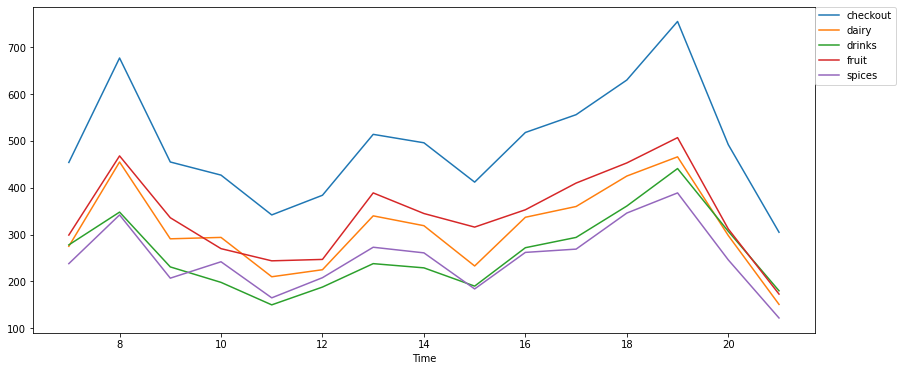

In [253]:
Group["customer_id"].unstack(level=0).plot.line()
plt.legend(bbox_to_anchor=(1, 1), loc='upper left', borderaxespad=0)

In [256]:
sort_sm

,timestamp,location,customer_id,location_next,Time,Day
19752,2019-09-06 07:00:00,dairy,f-1,spices,7,2019-09-06
19764,2019-09-06 07:04:00,spices,f-1,checkout,7,2019-09-06
19767,2019-09-06 07:05:00,checkout,f-1,fruit,7,2019-09-06
19771,2019-09-06 07:06:00,fruit,f-10,checkout,7,2019-09-06
19792,2019-09-06 07:11:00,checkout,f-10,fruit,7,2019-09-06
...,...,...,...,...,...,...
12856,2019-09-04 16:53:00,dairy,w-998,fruit,16,2019-09-04
12884,2019-09-04 16:57:00,fruit,w-998,checkout,16,2019-09-04
12892,2019-09-04 16:59:00,checkout,w-998,fruit,16,2019-09-04
12857,2019-09-04 16:53:00,fruit,w-999,checkout,16,2019-09-04


In [255]:
sort_sm.group_by('customer_id').count_unique()

AttributeError: 'DataFrame' object has no attribute 'group_by'

In [257]:
sns.lineplot(data=sort_sm, x="Time", y="customer_id", hue="location",  style="Day")

KeyboardInterrupt: 

- make a function that 